<a href="https://colab.research.google.com/github/AvonleaFisher/Analyzing-NYC-311-Service-Requests/blob/main/Exploring_the_Data/Line_and_Area_Charts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this section, we'll create summaries and visualizations to explore the data.

**Note:** Notebooks with exploratory visualizations have been broken up into multiple sections to reduce file size. Dependencies required across all EDA notebooks are imported below. To view animated plots that do not render on GitHub, enter the URL into [Jupyter Notebook Viewer](https://nbviewer.jupyter.org/).

# Loading Dependencies

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.collocations import *
from nltk import FreqDist
from nltk.probability import FreqDist
from os import path
from PIL import Image
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud, STOPWORDS

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import random
import plotly.io as pio

#display plotly figures
pio.renderers.default = "plotly_mimetype+notebook_connected"

# Importing the Data
The data used in this notebook can be accessed via the following sharable Google Drive link:

[community_board_311.csv](https://drive.google.com/file/d/1sWrkeaPOhpn37nxT9_zk2vs009nZOrlB/view?usp=sharing)

In [2]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/Colab Notebooks/community_board_311.csv' #change path to your Google Drive file location
df = pd.read_csv(path, index_col=0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [3]:
df.columns

Index(['created_date', 'complaint_type', 'agency', 'community_board',
       'latitude', 'longitude', 'descriptor', 'borough', 'day', 'month',
       'day_of_week', 'hour', 'area_sqmi', 'count_hosp_clinic',
       'count_libraries', 'count_parks', 'count_public_schools',
       'crime_per_1000', 'female_15_19', 'female_20_24', 'female_25_29',
       'female_30_34', 'female_35_39', 'female_40_44', 'female_45_49',
       'female_50_54', 'female_55_59', 'female_60_64', 'male_10_14',
       'male_15_19', 'male_20_24', 'male_25_29', 'male_30_34', 'male_35_39',
       'male_40_44', 'male_45_49', 'male_50_54', 'male_55_59', 'male_60_64',
       'under18_rate', 'over65_rate', 'lots_total', 'lots_vacant',
       'pct_white_nh', 'pct_black_nh', 'pct_asian_nh', 'pct_other_nh',
       'pct_hispanic', 'mean_commute', 'pop_change_00_10', 'pct_clean_strts',
       'unemployment', 'poverty_rate', 'lep_rate_boro', 'pct_hh_rent_burd'],
      dtype='object')

# Line Plot: Total Calls by Hour and Agency
We'll create a line plot to visualize how calls are distributed across different hours of the day among the top agencies. The function below creates a frequency dictionary with total calls by hour for a given agency.

In [4]:
def hour_call_freq_df(agency):

  """Takes in an agency name as a string. Returns a dataframe with agencies 
     and the total number of calls related to the given agency that were made 
     at each hour of the day."""

  subset = df[df.agency==agency]
    
  call_freqs_by_hour = {}
    
  for hour in subset.hour:
    
      if hour not in call_freqs_by_hour: 
            call_freqs_by_hour[hour] = 1
        
      else:
            call_freqs_by_hour[hour] += 1
  
  freq_df = pd.DataFrame.from_dict(call_freqs_by_hour, orient='index',
                                   columns=['{}'.format(agency)])
    
  return freq_df.sort_index()

Below, we create dictionaries for each of the top 5 agencies that receive the most calls.

In [5]:
NYPD = hour_call_freq_df('NYPD')
HPD = hour_call_freq_df('HPD')
DPR = hour_call_freq_df('DPR')
DOT = hour_call_freq_df('DOT')
DEP = hour_call_freq_df('DEP')
DSNY = hour_call_freq_df('DSNY')

For each dictionary, hours are displayed on the x-axis and total calls are displayed on the y-axis.

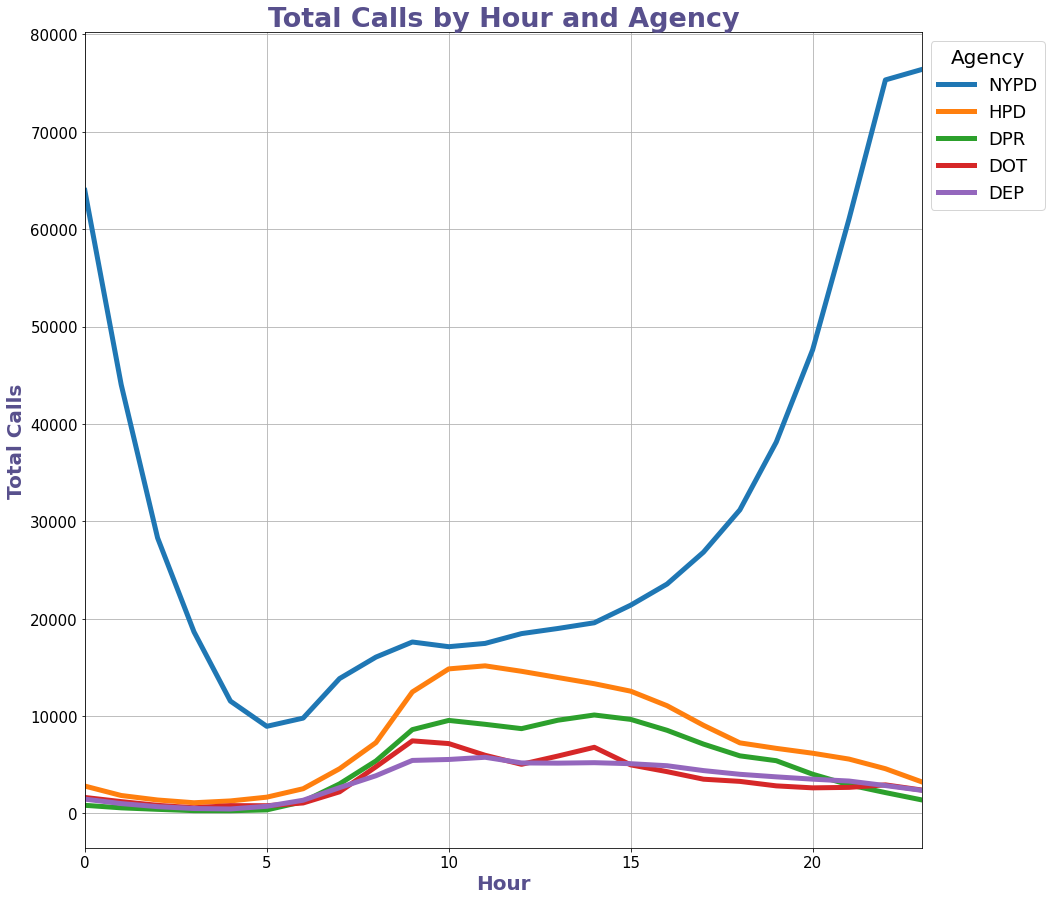

In [6]:
font_dict = dict(size=20, color="#58508d", fontweight='bold')
title_font_dict = dict(size=27, color="#58508d", fontweight='bold')

plt.figure(figsize=(15, 15))
plt.plot(NYPD.index, NYPD.NYPD, label="NYPD", linewidth=5)
plt.plot(HPD.index, HPD.HPD, label="HPD", linewidth=5)
plt.plot(DPR.index, DPR.DPR, label="DPR", linewidth=5)
plt.plot(DOT.index, DOT.DOT, label="DOT", linewidth=5)
plt.plot(DEP.index, DEP.DEP, label="DEP", linewidth=5)
plt.ylabel('Total Calls', fontdict=font_dict)
plt.xlabel('Hour', fontdict=font_dict)
plt.title('Total Calls by Hour and Agency', fontdict=title_font_dict)
plt.legend(title="Agency", title_fontsize=20, fontsize=18, 
           bbox_to_anchor=[1,1]) #position legend outside of plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(right=23) 
plt.xlim(left=0) 
plt.grid()

Most calls to the NYPD are made between 8PM and 5AM. Calls to other top agencies, conversely, peak during the day.

## Area Plots for Call Volume by Complaint Type
To visualize how the volume of calls changes over time for specific complaint type categories, we'll create some area plots. The below function creates a dataframe with the day-by-day call frequencies for a given complaint type, which will allow these values to be easily plotted.

In [7]:
def call_freq_df(complaint_type):
  
  """Takes in a complaint type as a string. Returns a dataframe with dates 
     and the total number of calls related to the given complaint that were made 
     on each date."""
    
  subset = df[df.complaint_type==complaint_type]
    
  call_freqs_by_date = {}
    
  for date in subset.day:
    
      if date not in call_freqs_by_date: 
            call_freqs_by_date[date] = 1
        
      else:
            call_freqs_by_date[date] += 1
    
  freq_df = pd.DataFrame.from_dict(call_freqs_by_date, orient='index', 
                                   columns=['{}'.format(complaint_type)])
    
  return freq_df

In [8]:
#create subsetted dataframes with complaints related to COVID-19
noncompliance = call_freq_df('Noncompliance With Phased Reopening')
mgc = call_freq_df('Mass Gathering Complaint')

In [9]:
#create and show area plot for COVID-related complaints
covid_fig = go.Figure()


covid_fig.add_trace(go.Scatter(
    x=noncompliance.index, y=noncompliance['Noncompliance With Phased Reopening'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#FF0000'), name='Noncompliance W/ Phased Reopening',
    stackgroup='one' 
))

covid_fig.add_trace(go.Scatter(
    x=mgc.index, y=mgc['Mass Gathering Complaint'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#000000'), name="Mass Gathering Complaint",
    stackgroup='two'
))
    

covid_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.001
))


covid_fig.update_layout(title="COVID-19", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

covid_fig.show()

While calls related to non-compliance with phased reopening have been made at least since June, mass gathering complaints weren't recorded until October 19th, 2020. There were 587 total non-compliance complaints at their peak on July 17th.

In [10]:
#create subsetted dataframes with complaints related to noise
noise_r = call_freq_df('Noise - Residential')
noise_c = call_freq_df('Noise - Commercial')
noise_v = call_freq_df('Noise - Vehicle')
noise_s = call_freq_df('Noise - Street/Sidewalk')
noise = call_freq_df('Noise - Unspecified')

In [11]:
#create and show area plot
noise_fig = go.Figure()

noise_fig.add_trace(go.Scatter(
    x=noise_r.index, y=noise_r['Noise - Residential'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#003f5c'), name="Noise - Residential",
    stackgroup='one'
))
    
noise_fig.add_trace(go.Scatter(
    x=noise_s.index, y=noise_s['Noise - Street/Sidewalk'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#58508d'), name='Noise - Street/Sidewalk',
    stackgroup='two' 
))

noise_fig.add_trace(go.Scatter(
    x=noise_v.index, y=noise_v['Noise - Vehicle'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#bc5090'), name='Noise - Vehicle',
    stackgroup='three' 
))


noise_fig.add_trace(go.Scatter(
    x=noise_c.index, y=noise_c['Noise - Commercial'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#ffa600'), name='Noise - Commercial',
    stackgroup='four' 
))

noise_fig.add_trace(go.Scatter(
    x=noise.index, y=noise['Noise - Unspecified'],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#003f5c'), name="Noise - Unspecified",
    stackgroup='one'
))

noise_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

noise_fig.update_layout(title="Noise", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

noise_fig.show()

Residential noise complaints are the most common among complaint types in this plot, followed by street/sidewalk, vehicle, and commercial noise complaints.

In [12]:
#create subsetted dataframes with complaints related to street and noise condition 
street = call_freq_df('Street Condition')
sidewalk = call_freq_df('Sidewalk Condition')

In [13]:
#create and show area plot
condition_fig = go.Figure()
condition_fig.add_trace(go.Scatter(
    x=street.index, y=street["Street Condition"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#22DDD3'), name="Street Condition",
    stackgroup='one'
    ))
    
condition_fig.add_trace(go.Scatter(
    x=sidewalk.index, y=sidewalk["Sidewalk Condition"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#6722DD'), name="Sidewalk Condition",
    stackgroup='one' 


))

condition_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))

condition_fig.update_layout(title="Sidewalk and Street Condition", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

condition_fig.show()

Calls related to sidewalk condition are more common than those related to street condition. There is no single peak for either complaint type. The total number of calls per day in these categories ranges from 30-391.

In [14]:
#create subsetted dataframes with complaints related to trees
dt = call_freq_df('Damaged Tree')
ot = call_freq_df('Overgrown Tree/Branches')
dd = call_freq_df('Dead/Dying Tree')
nt = call_freq_df('New Tree Request')

In [15]:
#create and show area plot (damaged trees)
damaged_tree_fig = go.Figure()
damaged_tree_fig.add_trace(go.Scatter(
    x=dt.index, y=dt["Damaged Tree"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#228B22'), name="Damaged Trees",
    stackgroup='one'
    ))

damaged_tree_fig.update_layout(title="Damaged Trees", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

damaged_tree_fig.show()

The data for this complaint type was plotted independently because there is a clear peak that occurs on August 4th, with nearly 14k calls related to damaged trees. This peak causes the data for other dates to appear insignificant, despite the relatively high volume of complaints related to damaged trees that occured throughout the summer. One August 5th, there were more than 8k calls, followed by 3k on August 6th. This high call volume is attributable to [Hurricane Isaias](https://www.ny1.com/nyc/all-boroughs/weather/2020/08/04/isaias-new-york-city-august-4), which resulted in downed trees throughout the entire city in early August.

In [16]:
# #create and show area plot (other tree-related complaints)
tree_fig = go.Figure()

tree_fig.add_trace(go.Scatter(
    x=ot.index, y=ot["Overgrown Tree/Branches"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#8B4513'), name="Overgrown Tree/Branches",
    stackgroup='two'
    ))

tree_fig.add_trace(go.Scatter(
    x=dd.index, y=dd["Dead/Dying Tree"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#C4285F'), name="Dead/Dying Tree",
    stackgroup='three'
    ))

tree_fig.add_trace(go.Scatter(
    x=nt.index, y=nt["New Tree Request"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#491BE5'), name="New Tree Request",
    stackgroup='four'
    ))

tree_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
))


tree_fig.update_layout(title="Other Tree-Related Requests", height=700,
                  xaxis_title="Date",
                  yaxis_title="Total Calls", 

font=dict(family="silom",
          size=14, color="#58508d"))

tree_fig.show()

New tree requests appear to be relatively uncommon. Calls related to overgrown and dying trees peaked at the same date as damaged trees, on August 4th, albeit with significantly fewer calls. 

In [17]:
#create subsetted dataframes with complaints related to parking/traffic/vehicles
driveway = call_freq_df('Blocked Driveway')
parking = call_freq_df('Illegal Parking')
abandoned = call_freq_df('Abandoned Vehicle')
traffic = call_freq_df('Traffic')

In [18]:
# #create and show area plot
parking_fig = go.Figure()

parking_fig.add_trace(go.Scatter(
    x=parking.index, y=parking["Illegal Parking"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#FCF73C'), name="Illegal Parking",
    stackgroup='two'
    ))

parking_fig.add_trace(go.Scatter(
    x=driveway.index, y=driveway["Blocked Driveway"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#f288ac'), name="Blocked Driveway",
    stackgroup='one'
    ))

parking_fig.add_trace(go.Scatter(
    x=abandoned.index, y=abandoned["Abandoned Vehicle"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#491BE5'), name="Abandoned Vehicle",
    stackgroup='three'
    ))

parking_fig.add_trace(go.Scatter(
    x=traffic.index, y=traffic["Traffic"],
    hoverinfo='x+y',
    mode='lines',
    line=dict(width=0.5, color='#2BD51D'), name="Traffic",
    stackgroup='four'
    ))

parking_fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

parking_fig.update_layout(title="Vehicles and Traffic",
                  xaxis_title="Date", height=700,
                  yaxis_title="Total Calls", 


font=dict(family="silom",
          size=14, color="#58508d"))

parking_fig.show()

Illegal parking complaints are the most common in the above graph, followed by blocked driveway complaints and abandoned vehicle complaints. Traffic-related calls never exceeded 30 per day.

# References

[Filled Area Plots in Python](https://plotly.com/python/filled-area-plots/)